###Importing data and packages

In [98]:
import pandas as pd
import numpy as np
import plotly.express as px
import time
import datetime
import plotly.graph_objects as go
from datetime import timedelta

season = str(2020)

df = pd.read_csv(f'data/pbp-{season}.csv')

In [100]:
#Run another file to scrape 33 webpages for primary color of each team, limit how often you do this
get_colors_again = False

if get_colors_again:
    %run team_colors.ipynb
    time.sleep(10)
    df_primary_colors = pd.read_csv('data/team_colors.csv')
else:
    df_primary_colors = pd.read_csv('data/team_colors.csv')

###Cleaning the data

In [101]:
df = df[['GameId','GameDate', 'OffenseTeam', 'DefenseTeam','NextScore', 'Down', 'ToGo', 'YardLine', 'TeamWin', 'Yards', 'PlayType', 'IsTouchdown']]

In [102]:
# Calculate avg yard per play on first down, offensively
aypp_offense = df[df['Down']==1].groupby(['OffenseTeam']).describe()[('Yards', 'mean')].reset_index()
aypp_offense.columns = aypp_offense.columns.get_level_values(0)

# Calculate avg yard per play on first down, defensively
aypp_defense = df[df['Down']==1].groupby(['DefenseTeam']).describe()[('Yards', 'mean')].reset_index()
aypp_defense.columns = aypp_defense.columns.get_level_values(0)

# Merge relevant tables to create graphic below
aypp = pd.merge(aypp_offense, aypp_defense, left_on='OffenseTeam', right_on='DefenseTeam', suffixes=('_offense', '_defense')).drop(columns=['DefenseTeam'])
df_merged = pd.merge(aypp, df_primary_colors, left_on='OffenseTeam', right_on='team')

###Create a visualization to show first down efficiency on offense and defense for each team

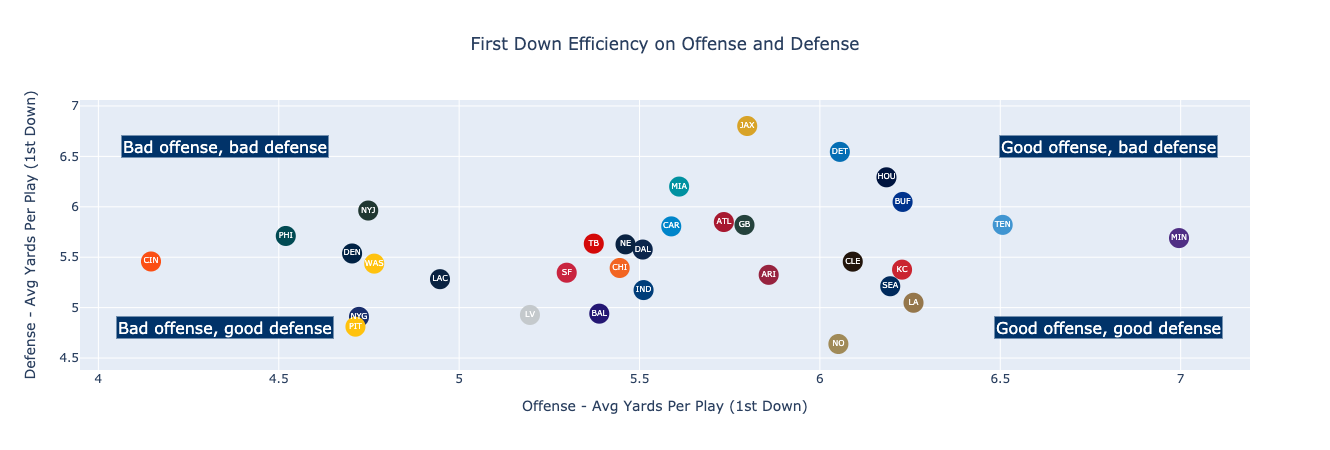

In [160]:
fig = go.Figure(
    data=go.Scatter(
        x=df_merged['Yards_offense'],
        y=df_merged['Yards_defense'],
        text=df_merged['OffenseTeam'],
        textfont=dict(
            size=8, 
            color='white'
        ),
        mode='markers+text',
        marker=dict(
            size=20,
            color=df_merged['color']
        )
    )
)
fig.update_layout(
    title='First Down Efficiency on Offense and Defense',
    title_x = 0.5,
    xaxis_title='Offense - Avg Yards Per Play (1st Down)',
    yaxis_title='Defense - Avg Yards Per Play (1st Down)',
    legend_title="Legend Title"
)

fig.add_annotation(
    x=6.8,
    y=4.7,
    text="Good offense, good defense",
    showarrow=False,
    bgcolor="#013369",
        font=dict(
        size=16,
        color="#ffffff"
        ),
    yshift=10
)

fig.add_annotation(
    x=6.8,
    y=6.7,
    text="Good offense, bad defense",
    showarrow=False,
    bgcolor="#013369",
        font=dict(
        size=16,
        color="#ffffff"
        ),
    yshift=-10
)

fig.add_annotation(
    x=4.35,
    y=4.7,
    text="Bad offense, good defense",
    showarrow=False,
    bgcolor="#013369",
        font=dict(
        size=16,
        color="#ffffff"
        ),
    yshift=10
)

fig.add_annotation(
    x=4.35,
    y=6.7,
    text="Bad offense, bad defense",
    showarrow=False,
    bgcolor="#013369",
        font=dict(
        size=16,
        color="#ffffff"
        ),
    yshift=-10
)

fig.show()

###Convert date of game to the week of the season ("Week 1, Week 2, etc)

In [104]:
df['date_to_datetime'] = df['GameDate'].apply(lambda x: pd.to_datetime(x))
df['day_of_week'] = df['date_to_datetime'].dt.dayofweek

In [105]:
def convert_date_to_sunday(row):
    if row['day_of_week'] == 6:
        return str((datetime.datetime.strptime(row['GameDate'], '%Y-%m-%d')).date())
    elif row['day_of_week'] == 0:
        return str((datetime.datetime.strptime(row['GameDate'], '%Y-%m-%d') - timedelta(days=1)).date())
    elif row['day_of_week'] == 3:
        return str((datetime.datetime.strptime(row['GameDate'], '%Y-%m-%d') + timedelta(days=3)).date())
    elif row['day_of_week'] == 1:
        return str((datetime.datetime.strptime(row['GameDate'], '%Y-%m-%d') - timedelta(days=2)).date())
    elif row['day_of_week'] == 5:
        return str((datetime.datetime.strptime(row['GameDate'], '%Y-%m-%d') + timedelta(days=1)).date())
    elif row['day_of_week'] == 2:
        return str((datetime.datetime.strptime(row['GameDate'], '%Y-%m-%d') - timedelta(days=3)).date())

df['sunday_week'] = df.apply(convert_date_to_sunday, axis=1)
dates = np.sort(df['sunday_week'].unique())
weeks = range(1, len(dates) + 1)
date_to_week_dict = dict(zip(dates, weeks))
df['week'] = df['sunday_week'].apply(lambda x: date_to_week_dict[x])

In [116]:
grouped_off = df[['OffenseTeam', 'week', 'Yards']].groupby(['OffenseTeam', 'week']).describe()[('Yards', 'mean')].reset_index()
grouped_def = df[['DefenseTeam', 'week', 'Yards']].groupby(['DefenseTeam', 'week']).describe()[('Yards', 'mean')].reset_index()
grouped_off.columns = grouped_off.columns.get_level_values(0) + grouped_off.columns.get_level_values(1)
grouped_def.columns = grouped_def.columns.get_level_values(0) + grouped_def.columns.get_level_values(1)
grouped = pd.merge(grouped_off,grouped_def, left_on=['OffenseTeam', 'week'], right_on=['DefenseTeam', 'week'], suffixes=('_off', '_def'))
grouped_cols = pd.merge(grouped,df_primary_colors, left_on='OffenseTeam', right_on='team')
grouped_cols = grouped_cols[[ 'team', 'week', 'Yardsmean_off', 'Yardsmean_def', 'color']]

In [168]:
grouped_cols

,team,week,Yardsmean_off,Yardsmean_def,color
0,ARI,1,4.387755,4.753247,#97233F
1,ARI,2,4.561224,4.038462,#97233F
2,ARI,3,5.649351,4.348837,#97233F
3,ARI,4,3.555556,4.849462,#97233F
4,ARI,5,5.967033,3.390244,#97233F
...,...,...,...,...,...
443,WAS,11,4.300000,3.243902,#FFC20F
444,WAS,12,4.409091,3.971831,#FFC20F
445,WAS,13,3.393617,4.000000,#FFC20F
446,WAS,14,2.383721,4.677083,#FFC20F


In [167]:
season = str(2020)
df_outcomes = pd.read_csv(f'data/game_outcomes_{season}.csv')
df_outcomes

,team,week,win,points_scored,points_given_up
0,KC,1,1.0,34.0,20.0
1,HOU,1,0.0,20.0,34.0
2,BUF,1,1.0,27.0,17.0
3,NYJ,1,0.0,17.0,27.0
4,ATL,1,0.0,25.0,38.0
...,...,...,...,...,...
471,LA,16,0.0,9.0,20.0
472,DAL,16,1.0,37.0,17.0
473,PHI,16,0.0,17.0,37.0
474,GB,16,1.0,40.0,14.0


In [169]:
df_for_vis = pd.merge(grouped_cols, df_outcomes, on=['team', 'week'])
df_for_vis

,team,week,Yardsmean_off,Yardsmean_def,color,win,points_scored,points_given_up
0,ARI,1,4.387755,4.753247,#97233F,1.0,24.0,20.0
1,ARI,2,4.561224,4.038462,#97233F,1.0,30.0,15.0
2,ARI,3,5.649351,4.348837,#97233F,0.0,23.0,26.0
3,ARI,4,3.555556,4.849462,#97233F,0.0,21.0,31.0
4,ARI,5,5.967033,3.390244,#97233F,1.0,30.0,10.0
...,...,...,...,...,...,...,...,...
427,TEN,11,5.297619,3.876543,#4095D1,1.0,30.0,24.0
428,TEN,12,4.697917,3.930233,#4095D1,1.0,45.0,26.0
429,TEN,13,5.790698,4.946809,#4095D1,0.0,35.0,41.0
430,TEN,14,6.349398,4.914634,#4095D1,1.0,31.0,10.0


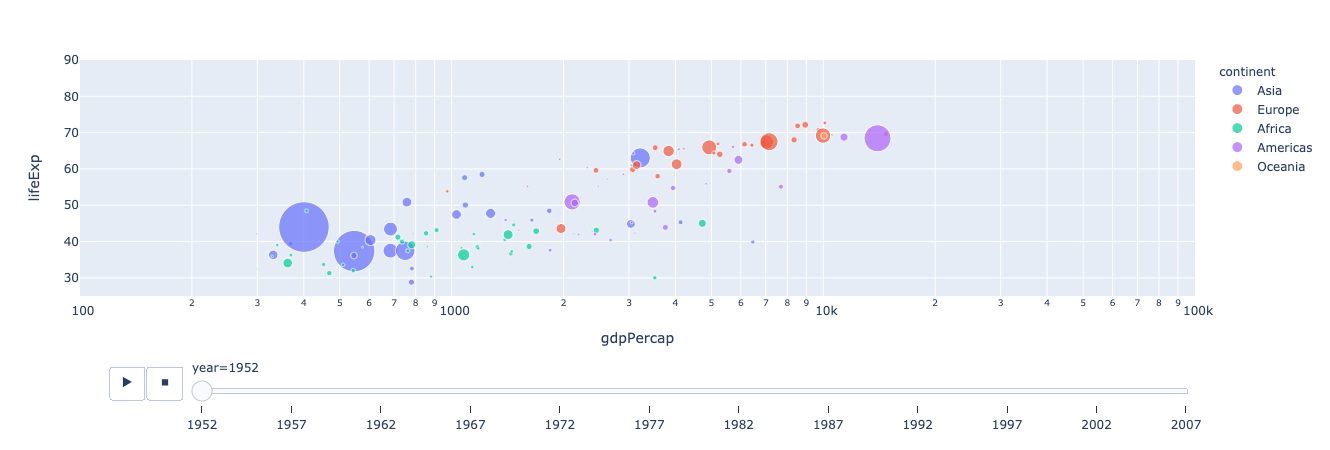

In [162]:
df_gap = px.data.gapminder()
px.scatter(df_gap, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

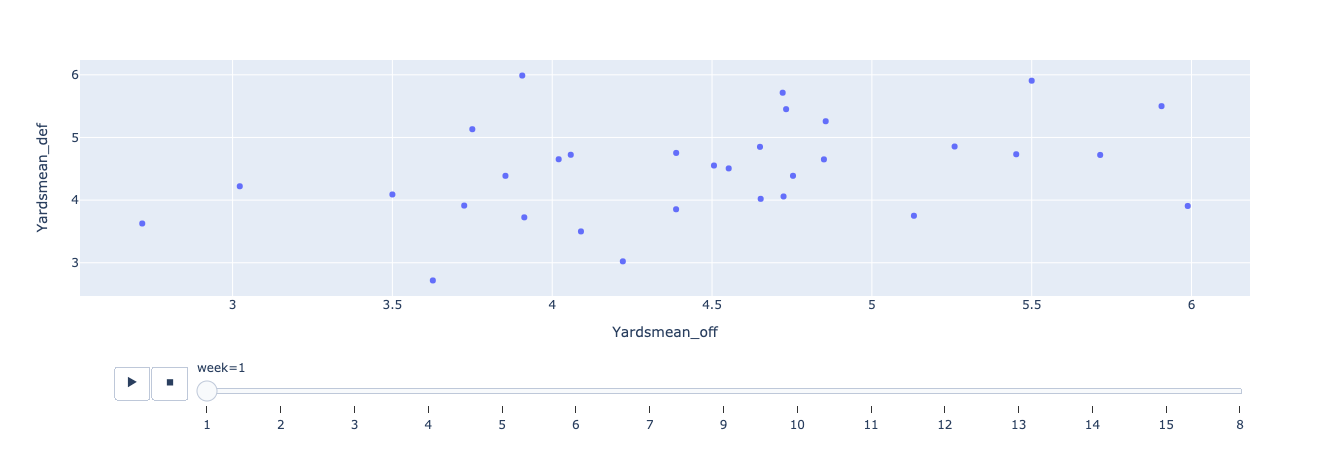

In [164]:
px.scatter(grouped_cols, x='Yardsmean_off', y='Yardsmean_def', animation_frame='week') #, animation_group="country") #,
#            size="pop", color="continent", hover_name="country",log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])

# fig = go.Figure(data=go.Scatter(x=df_merged['Yards_offense'],
#                                 y=df_merged['Yards_defense'],
#                                 text=df_merged['OffenseTeam'],
#                                 textfont=dict(size=8, color='white'),
#                                 mode='markers+text',
#                                 marker=dict(size=20,color=df_merged['color']))
#                )

# fig.update_layout(title='First Down Efficiency on Offense and Defense')
# # ADD AXES
# fig.show()

In [91]:
df.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4


In [33]:
avg_yards_per_game = df.gxroupby(['OffenseTeam', 'GameDate'])['Yards'].sum()
# avg_yards_per_game = avg_yards_per_game.reset_index()

KeyError: 'GameDate'

In [13]:
avg_yards_per_game

NameError: name 'avg_yards_per_game' is not defined

In [ ]:
# df['offense_penalty_yards'] = df[(df['PenaltyTeam'] == df['OffenseTeam'])]['PenaltyYards']
# df['defense_penalty_yards'] = df[(df['PenaltyTeam'] == df['DefenseTeam'])]['PenaltyYards']
# df[['offense_penalty_yards','defense_penalty_yards']].fillna(value=0, inplace=True)